In [6]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""

!python3 -V

Python 3.10.12


In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
Centroid estimator tools
"""

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, kp=1):
    xhat_dt = - kp*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

def dyn_L_estimation(lhat_0, t, Lb, l_ij, kp=1):
    lhat_dt = - kp*(Lb.dot(lhat_0) - Lb.dot(l_ij))
    return lhat_dt

## Centroid estimation

In [9]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # two legends

from utils.toolbox import kw_def_patch, unicycle_patch

def plot_centroid_estimation(ax, X, Z, tf=1, freq_inv=100, kp=1,
                             legend=False, xlab=False, ylab=False):
    N = X.shape[0]

    xc = np.sum(X, axis=0)/N
    xb = X.flatten()

    scale = np.max(np.linalg.norm(X-xc,axis=1))

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 0]) # why?

    # Simulation -------------------------------------------------------
    t = np.linspace(0, tf, int(freq_inv*tf+1))
    
    xhat_0 = np.zeros_like(xb)
    xhat = odeint(dyn_centroid_estimation, xhat_0, t, args=(Lb,xb,kp))

    xc_est0 = X
    xc_est = (xb - xhat[-1]).reshape(X.shape)
    # ------------------------------------------------------------------

    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([xc[0]-ds, xc[0]+ds, xc[1]-ds, xc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N,tf*1000,freq_inv/1e3) + "\n"
    title = title + r"$k_p$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(kp,min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([X[edge[0]-1,0], X[edge[1]-1,0]], [X[edge[0]-1,1], X[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    phi = np.pi/3
    for n in range(N):
        icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
        ax.add_patch(icon)

    # Points
    ax.scatter(xc[0], xc[1], c="k", marker=r"$x$", s=scale*100)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)

### Some examples

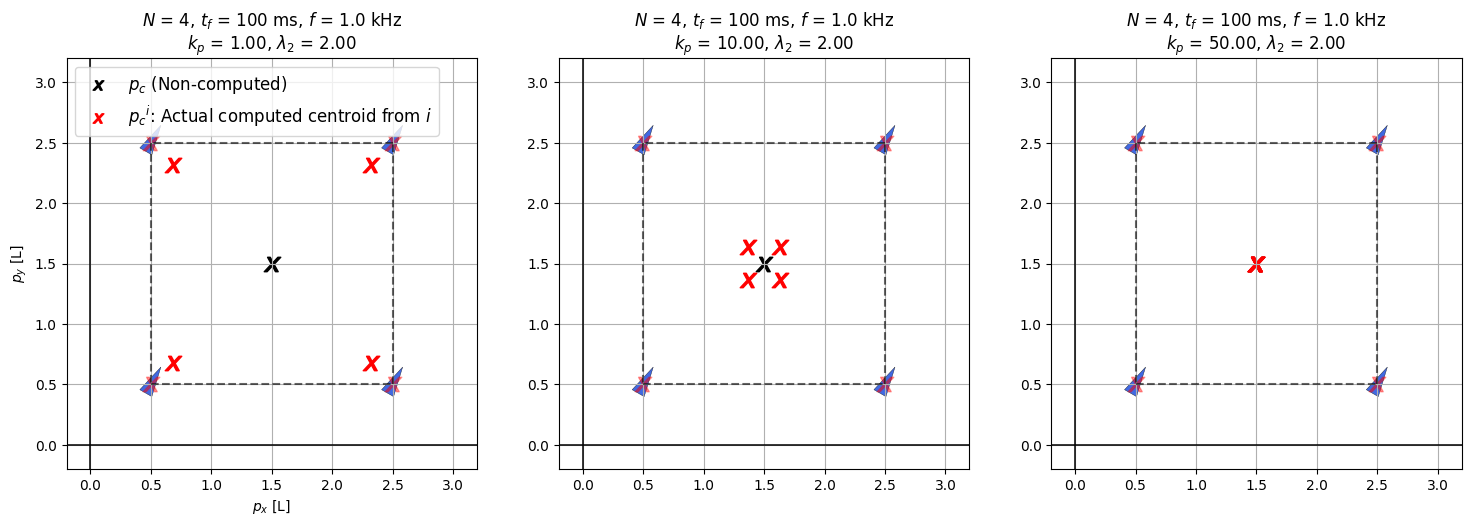

In [10]:
## Parameters #####
p = np.array([[1,1],[-1,1],[-1,-1],[1,-1]]) + np.array([1.5,1.5])
Z = ((1,2), (2,3), (3,4), (4,1))

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, tf=0.1, freq_inv=100*10, kp=1, legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, tf=0.1, freq_inv=100*10, kp=10)
plot_centroid_estimation(ax[2], p, Z, tf=0.1, freq_inv=100*10, kp=50)

# Show the plot!
plt.show()

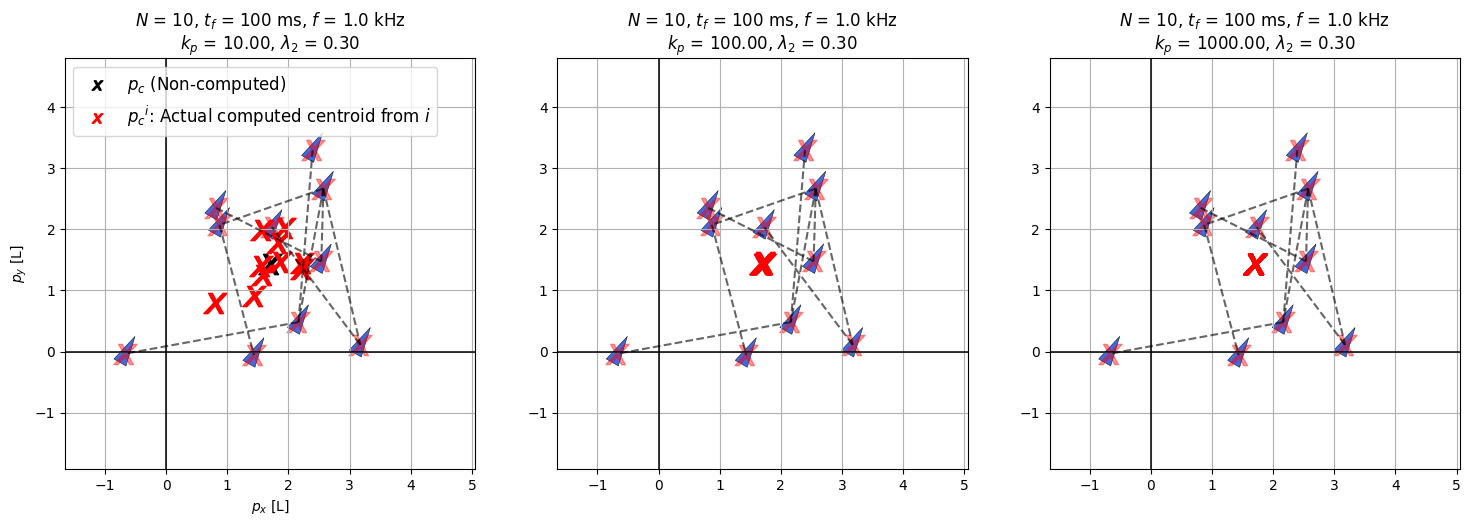

In [21]:
from utils.toolbox import XY_distrib, gen_random_graph

## Parameters #####
pc = np.array([1.2,1.5])
lims = np.array([2,2])

N = 10
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, tf=0.1, freq_inv=100*10, kp=10, legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, tf=0.1, freq_inv=100*10, kp=100)
plot_centroid_estimation(ax[2], p, Z, tf=0.1, freq_inv=100*10, kp=1000)

# Show the plot!
plt.show()

## Ascending direction estimation

In [ ]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # two legends

from utils.toolbox import kw_def_patch, unicycle_patch

def plot_centroid_estimation(ax, X, Z, tf=1, freq_inv=100, kp=1,
                             legend=False, xlab=False, ylab=False):
    N = X.shape[0]

    xc = np.sum(X, axis=0)/N
    xb = X.flatten()

    scale = np.max(np.linalg.norm(X-xc,axis=1))

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 0]) # why?

    # Simulation -------------------------------------------------------
    t = np.linspace(0, tf, int(freq_inv*tf+1))
    
    lhat_0 = np.zeros_like(xb)
    xhat = odeint(dyn_L_estimation, lhat_0, t, args=(Lb,xb,kp))

    xc_est0 = X
    xc_est = (xb - xhat[-1]).reshape(X.shape)
    # ------------------------------------------------------------------

    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([xc[0]-ds, xc[0]+ds, xc[1]-ds, xc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N,tf*1000,freq_inv/1e3) + "\n"
    title = title + r"$k_p$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(kp,min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([X[edge[0]-1,0], X[edge[1]-1,0]], [X[edge[0]-1,1], X[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    phi = np.pi/3
    for n in range(N):
        icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
        ax.add_patch(icon)

    # Points
    ax.scatter(xc[0], xc[1], c="k", marker=r"$x$", s=scale*100)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)

### Some examples